An astronomial mistake in my script could be removing the outlier. We'll see that after 18 Hours

In [107]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns',800)

### Some more raw features
https://www.kaggle.com/rupeshwadibhasme/lb-0-578-upgraded-version-stack-lgblasgbdt-kernal/code

In [83]:
del train, test

In [84]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [85]:
print (train.shape)

(4209, 378)


In [86]:
train = train.loc[train['y'] < 170]

In [87]:
print (train.shape)

(4208, 378)


In [88]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl=LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(train[c].values)
        test[c] = lbl.transform(test[c].values)

In [89]:
y = train['y']
train.drop('y',axis=1,inplace=True)
combine = pd.concat([train, test])

In [90]:
columns=['X1','X2','X3','X4','X5','X6','X8']

one_hots = pd.DataFrame()
for column in columns:
    temp = pd.get_dummies(pd.Series(combine[column]))
    one_hots = pd.concat([one_hots, temp], axis=1)

In [91]:
# define new train
ohe_train = one_hots[:train.shape[0]]
ohe_test = one_hots[train.shape[0]:]

In [92]:
print (ohe_train.shape)
print (ohe_test.shape)

(4208, 158)
(4209, 158)


In [93]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

In [94]:
ohe_train = df_column_uniquify(ohe_train)
ohe_test = df_column_uniquify(ohe_test)

In [95]:
# get column sum
col_train_sum = ohe_train.sum(axis=0)
col_test_sum = ohe_test.sum(axis=0)

In [96]:
train_ind = col_train_sum.loc[lambda x: x < 200]
test_ind = col_test_sum.loc[lambda x: x < 200]

In [97]:
cols_to_drop = []
for k,v in train_ind.iteritems():
    cols_to_drop.append(k)

In [100]:
ohe_train.drop(cols_to_drop, axis=1, inplace=True)
ohe_test.drop(cols_to_drop, axis=1, inplace=True)

/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [121]:
print (ohe_train.shape)
print (ohe_test.shape)

(4208, 45)
(4209, 45)


Taking 45 OHE features in the main file

### L0 Features

In [102]:
del full_train, full_test

In [147]:
full_train = pd.read_csv("new_features/full_train_v2.csv")
full_test = pd.read_csv("new_features/full_test_v2.csv")

In [148]:
print (full_train.shape)
print (full_test.shape)

(4208, 200)
(4209, 199)


Lets plot a correlation matrix and check the strength of variables.

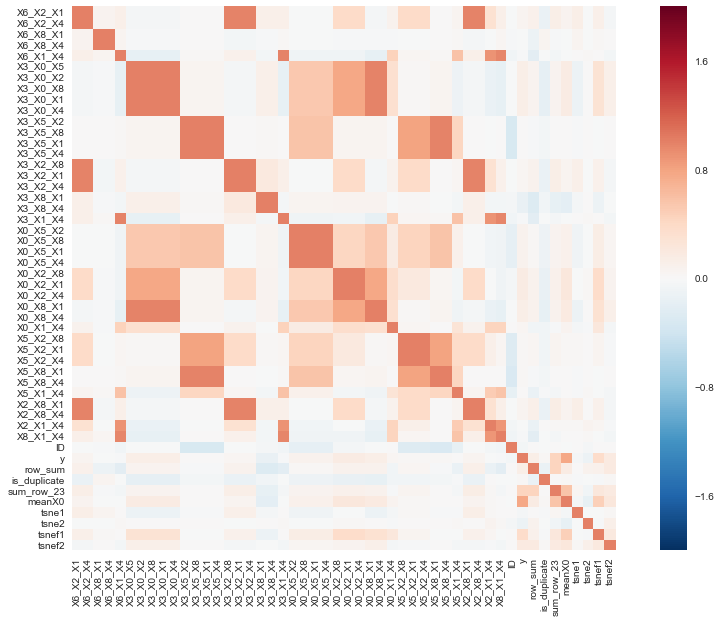

In [118]:
corrmat = full_train.iloc[:,150:200].corr()
f,ax = plt.subplots(figsize=(16,10))
sns.heatmap(corrmat, vmax= 2, square=True)

In [149]:
full_train = pd.concat([full_train.reset_index(drop=True), ohe_train],axis=1)
print(full_train.shape)

(4209, 245)


In [150]:
full_train = full_train.loc[full_train.index != 4208]
print(full_train.shape)

(4208, 245)


In [151]:
full_test = pd.concat([full_test, ohe_test],axis=1)
print(full_test.shape)

(4209, 244)


In [225]:
print (full_train.shape)

(4208, 245)


In [226]:
full_train.to_csv('new_features/full_train_v3.csv',index=False)
full_test.to_csv('new_features/full_test_v3.csv',index=False)

### L1 Features

In [4]:
p1_eval = pd.read_csv("pipeline/XGB_train_P1_eval.csv")
p2_eval = pd.read_csv("pipeline/XGB_train_P2_eval.csv")
p3_eval = pd.read_csv("pipeline/XGB_train_P3_eval.csv")
p4_eval = pd.read_csv("pipeline/XGB_train_P4_eval.csv")

p1_test = pd.read_csv("pipeline/XGB_train_P1_test.csv")
p2_test = pd.read_csv("pipeline/XGB_train_P2_test.csv")
p3_test = pd.read_csv("pipeline/XGB_train_P3_test.csv")
p4_test = pd.read_csv("pipeline/XGB_train_P4_test.csv")

In [57]:
full_train.loc[:,'xg1'] = p1_eval['model_version']
full_train.loc[:,'xg2'] = p2_eval['model_version'] 
full_train.loc[:,'xg3'] = p3_eval['model_version']
full_train.loc[:,'xg4'] = p4_eval['model_version']

full_test.loc[:,'xg1'] = p1_test['model_version']
full_test.loc[:,'xg2'] = p2_test['model_version'] 
full_test.loc[:,'xg3'] = p3_test['model_version']
full_test.loc[:,'xg4'] = p4_test['model_version']

Since all l1 values are correlated, we'll take a new column mean and drop those values

In [64]:
full_train.loc[:,'xgb_ave'] = full_train.loc[:,['xg1','xg2','xg3','xg4']].mean(axis=1)
full_test.loc[:,'xgb_ave'] = full_test.loc[:,['xg1','xg2','xg3','xg4']].mean(axis=1)

In [66]:
full_train.drop(['xg1','xg2','xg3','xg4'],axis=1,inplace=True)
full_test.drop(['xg1','xg2','xg3','xg4'],axis=1,inplace=True)

In [77]:
cols_to_use = list(set(full_train.columns) - set(['ID','y']))

### Functions

In [176]:
def get_sklearn_stack_data(model,train,col,label,test):
    ID = []
    R2_Score = []
    train = train.reset_index(drop=True)
    kf = KFold(n_splits=5,shuffle=False)
    i=0
    for train_index, test_index in kf.split(train):
        print("Training "+str(i+1)+' Fold')
        X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
        y_train, y_test = label.iloc[train_index],label.iloc[test_index]
        model.fit(X_train[col],y_train)
        pred = model.predict(X_test[col])
        X_test['label'] = list(y_test)
        X_test['predicted'] = pred
        r2 = r2_score(y_test,pred)
        rmse = MSE(y_test,pred)**0.5
        print('R2 Scored of Fold '+str(i+1)+' is '+str(r2))
        R2_Score.append(r2)
        ID.append(X_test['ID'])
        if i==0:
            Final = X_test
        else:
            Final = Final.append(X_test,ignore_index=True)
        i+=1
    print('Start Training')
    model.fit(train[col],label)
    Final_pred = model.predict(test[col])
    Final_pred = pd.DataFrame({'ID':test['ID'],'y':Final_pred})
    print('Calculating In-Bag R2 Score')
    print(r2_score(label, model.predict(train[col])))
    print('Calculating Out-Bag R2 Score')
    print(np.mean(R2_Score))

    return Final,Final_pred


def get_xgb_stack_data(params,rounds,train,col,label,test):
    ID = []
    train = train.reset_index(drop=True)
    kf = KFold(n_splits=5,shuffle=False)
    i=0
    R2_Score = []
    for train_index, test_index in kf.split(train):
        print("Training "+str(i+1)+' Fold')
        X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
        y_train, y_test = label.iloc[train_index],label.iloc[test_index]
        dtrain = xgb.DMatrix(X_train[col],y_train)
        dtest = xgb.DMatrix(X_test[col])
        model = xgb.train(params,dtrain,num_boost_round=rounds)
        pred = model.predict(dtest)
        X_test['label'] = list(y_test)
        X_test['predicted'] = pred
        r2 = r2_score(y_test,pred)
        print('R2 Scored of Fold '+str(i+1)+' is '+str(r2))
        R2_Score.append(r2)
    
        ID.append(X_test['ID'])
        if i==0:
            Final = X_test
        else:
            Final = Final.append(X_test,ignore_index=True)
        i+=1
    dtrain_ = xgb.DMatrix(train[col],label)
    dtest_ = xgb.DMatrix(test[col])
    print('Start Training')
    model_ = xgb.train(params,dtrain_,num_boost_round=rounds)
    Final_pred = model_.predict(dtest_)
    Final_pred = pd.DataFrame({'ID':test['ID'],'y':Final_pred})
    print('Calculating In-Bag R2 Score')
    print(r2_score(dtrain_.get_label(), model.predict(dtrain_)))
    print('Calculating Out-Bag R2 Score')
    print(np.mean(R2_Score))

    return Final,Final_pred


def get_lgb_stack_data(params,rounds,train,col,label,test):
    ID = []
    train = train.reset_index(drop=True)
    kf = KFold(n_splits=5,shuffle=False)
    i=0
    R2_Score = []
    RMSE = []
    for train_index, test_index in kf.split(train):
        print("Training "+str(i+1)+' Fold')
        X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
        y_train, y_test = label.iloc[train_index],label.iloc[test_index]
        train_lgb=lgb.Dataset(X_train[col],y_train)
        model = lgb.train(params,train_lgb,num_boost_round=rounds)
        pred = model.predict(X_test[col])
        X_test['label'] = list(y_test)
        X_test['predicted']= pred
        r2 = r2_score(y_test,pred)
        rmse = MSE(y_test,pred)**0.5
        print('R2 Scored of Fold '+str(i+1)+' is '+str(r2))
        R2_Score.append(r2)
        RMSE.append(rmse)
        print('RMSE of Fold '+str(i+1)+' is '+str(rmse))
        ID.append(X_test['ID'])
        if i==0:
            Final = X_test
        else:
            Final = Final.append(X_test,ignore_index=True)
        i+=1
    lgb_train_ = lgb.Dataset(train[col],label)
    print('Start Training')
    model_ = lgb.train(params,lgb_train_,num_boost_round=rounds)
    Final_pred = model_.predict(test[col])
    Final_pred = pd.DataFrame({'ID':test['ID'],'y':Final_pred})
    print('Calculating In-Bag R2 Score')
    print(r2_score(label, model.predict(train[col])))
    print('Calculating Out-Bag R2 Score')
    print(np.mean(R2_Score))
    print('Calculating In-Bag RMSE')
    print(MSE(label, model.predict(train[col]))**0.5)
    print('Calculating Out-Bag RMSE')
    print(np.mean(RMSE))
    return Final,Final_pred

In [82]:
## Input 1: GBDT

gb1 = GradientBoostingRegressor(n_estimators=2000,max_features=0.45,learning_rate=0.005,max_depth=6,min_samples_split=7)
gb1_train,gb1_test = get_sklearn_stack_data(gb1,full_train,cols_to_use,full_train['y'],full_test)

Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.51857653074
Training 2 Fold
R2 Scored of Fold 2 is 0.534203833385
Training 3 Fold
R2 Scored of Fold 3 is 0.558617694766
Training 4 Fold
R2 Scored of Fold 4 is 0.494667050676
Training 5 Fold
R2 Scored of Fold 5 is 0.592053629026
Start Training
Calculating In-Bag R2 Score
0.838473747302
Calculating Out-Bag R2 Score
0.539623747719


In [83]:
# Input 2: XGBOOST

y_mean = np.mean(full_train['y'])

xg_params = {
    'eta': 0.005,
    'max_depth': 6,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'subsample':0.95,
    'colsample_bytree':0.4,
    'base_score': y_mean # base prediction = mean(target)
}

xg_train, xg_test = get_xgb_stack_data(xg_params, 1000, full_train, cols_to_use, full_train['y'], full_test)

Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.554823148253
Training 2 Fold
R2 Scored of Fold 2 is 0.542557883097
Training 3 Fold
R2 Scored of Fold 3 is 0.594172486579
Training 4 Fold
R2 Scored of Fold 4 is 0.526946849785
Training 5 Fold
R2 Scored of Fold 5 is 0.621458969994
Start Training
Calculating In-Bag R2 Score
0.765795042757
Calculating Out-Bag R2 Score
0.567991867542


In [84]:
## Input 3: Random Forest

rf1 = RandomForestRegressor(n_estimators=1000, max_features=0.4,max_depth=6,min_samples_split=7)
rf_train,rf1_test = get_sklearn_stack_data(rf1, full_train, cols_to_use, full_train['y'], full_test)

Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.604668226894
Training 2 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 2 is 0.541222558625
Training 3 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 3 is 0.598526123155
Training 4 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 4 is 0.537616464784
Training 5 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 5 is 0.634020246848
Start Training
Calculating In-Bag R2 Score
0.657018372969
Calculating Out-Bag R2 Score
0.583210724061


In [75]:
sub_rof = pd.DataFrame({'ID':full_test.ID,'y':rf1_test.y})
sub_rof.to_csv('new_features/random_forest_9thjuly.csv',index=False) #  0.54887

In [85]:
#### Input 4: KNN Regressor

knn1 = KNeighborsRegressor(n_neighbors=7)
knn_train1,knn_test1 = get_sklearn_stack_data(knn1, full_train, cols_to_use, full_train['y'], full_test)

knn2 = KNeighborsRegressor(n_neighbors=11)
knn_train2,knn_test2 = get_sklearn_stack_data(knn2, full_train, cols_to_use, full_train['y'], full_test)

knn3 = KNeighborsRegressor(n_neighbors=5)
knn_train3,knn_test3 = get_sklearn_stack_data(knn3, full_train, cols_to_use, full_train['y'], full_test)


Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.176415578016
Training 2 Fold
R2 Scored of Fold 2 is 0.214239591798
Training 3 Fold
R2 Scored of Fold 3 is 0.242143682207
Training 4 Fold
R2 Scored of Fold 4 is 0.263666649028
Training 5 Fold
R2 Scored of Fold 5 is 0.245745681965
Start Training
Calculating In-Bag R2 Score
0.491339324447
Calculating Out-Bag R2 Score
0.228442236603
Training 1 Fold
R2 Scored of Fold 1 is 0.18991595474
Training 2 Fold
R2 Scored of Fold 2 is 0.183141341858
Training 3 Fold
R2 Scored of Fold 3 is 0.271310401292
Training 4 Fold
R2 Scored of Fold 4 is 0.263185889448
Training 5 Fold
R2 Scored of Fold 5 is 0.249019425072
Start Training
Calculating In-Bag R2 Score
0.430287860557
Calculating Out-Bag R2 Score
0.231314602482
Training 1 Fold
R2 Scored of Fold 1 is 0.186116678973
Training 2 Fold
R2 Scored of Fold 2 is 0.207701036927
Training 3 Fold
R2 Scored of Fold 3 is 0.223366657105
Training 4 Fold
R2 Scored of Fold 4 is 0.250897191682
Training 5 Fold
R2 Scored of Fold 5 is 0.189952082306
Sta

In [87]:
## Input 5: Extratrees

from sklearn.ensemble import ExtraTreesRegressor
ext1 = ExtraTreesRegressor(n_estimators=1000, max_depth=6, max_features=0.3,min_samples_split=7)
ext1_train,ext1_test = get_sklearn_stack_data(ext1,full_train,cols_to_use,full_train['y'],full_test)

Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.607114413013
Training 2 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 2 is 0.539455018575
Training 3 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 3 is 0.594750848764
Training 4 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 4 is 0.53658210905
Training 5 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 5 is 0.628245602494
Start Training
Calculating In-Bag R2 Score
0.621735275811
Calculating Out-Bag R2 Score
0.581229598379


In [95]:
## Input 6: SGD
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1_train, lr1_test = get_sklearn_stack_data(lr1,full_train, cols_to_use, full_train['y'],full_test)

Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.628802117658
Training 2 Fold
R2 Scored of Fold 2 is -202730.890746
Training 3 Fold
R2 Scored of Fold 3 is 0.59684377423
Training 4 Fold
R2 Scored of Fold 4 is 0.532682820371
Training 5 Fold
R2 Scored of Fold 5 is 0.634442762708
Start Training
Calculating In-Bag R2 Score
0.616851232426
Calculating Out-Bag R2 Score
-40545.6995948


In [99]:
## Input 7: LightGBM

# light gbm
params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'learning_rate': 0.025 , #small learn rate, large number of iterations
            'num_iterations': 1000,
            'bagging_fraction': 0.90,
            'bagging_freq': 1,
            'bagging_seed': 42,
            'feature_fraction': 0.45,
            'feature_fraction_seed': 42,
            'max_bin': 100,
            'max_depth': 6
        }

lgb_train, lgb_test = get_lgb_stack_data(params,800,full_train,cols_to_use,full_train['y'],full_test)

Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.570092577829
RMSE of Fold 1 is 8.10221105604
Training 2 Fold
R2 Scored of Fold 2 is 0.528286357462
RMSE of Fold 2 is 9.01419599794
Training 3 Fold
R2 Scored of Fold 3 is 0.578408606276
RMSE of Fold 3 is 8.01801500067
Training 4 Fold
R2 Scored of Fold 4 is 0.500066526453
RMSE of Fold 4 is 8.90545944888
Training 5 Fold
R2 Scored of Fold 5 is 0.610245418865
RMSE of Fold 5 is 7.17191442734
Start Training
Calculating In-Bag R2 Score
0.835453210706
Calculating Out-Bag R2 Score
0.557419897377
Calculating In-Bag RMSE
5.03917739691
Calculating Out-Bag RMSE
8.24235918618


### Level 1 Model Averaging

In [101]:
# level 1 models

stack_test = gb1_test.loc[:,['ID','y']]
stack_test.columns = [['ID','gbdt']]
stack_test['forest'] = rf1_test.loc[:,'y']
stack_test['knn1'] = knn_test1.loc[:,['y']]
stack_test['knn2'] = knn_test2.loc[:,['y']]
stack_test['knn3'] = knn_test3.loc[:,['y']]
stack_test['reg1'] = lr1_test.loc[:,['y']]
stack_test['trees'] = ext1_test.loc[:,['y']]
stack_test['light'] = lgb_test.loc[:,['y']]
stack_test['xgb'] = xg_test.loc[:,['y']]
del stack_test['ID']

In [107]:
from scipy.stats.mstats import gmean,hmean

In [111]:
row_geom = stack_test.apply(gmean, axis=1)
row_hmean = stack_test.apply(hmean, axis=1)

In [114]:
row_mean = stack_test.mean(axis=1)

In [117]:
comp_mean = pd.DataFrame({'geom':row_geom,'hmean':row_hmean,'average':row_mean})

In [118]:
# make a final submission with geometric mean
sub_final = pd.DataFrame({'ID':full_test.ID, 'y':row_geom})
sub_final.to_csv('new_features/geometric_mean.csv', index=False) #0.53362

In [119]:
# weighted average
sub_ave = pd.read_csv("new_features/model_averaging_8thjuly.csv")

In [120]:
weigh_sol = sub_ave['y']*0.7 + sub_final['y']*0.3

In [127]:
sub = pd.DataFrame({'ID':full_test.ID, 'y':weigh_sol})


In [123]:
leaks = {
    1:71.34112,
    12:109.30903,
    23:115.21953,
    28:92.00675,
    42:87.73572,
    43:129.79876,
    45:99.55671,
    57:116.02167,
    3977:132.08556,
    88:90.33211,
    89:130.55165,
    93:105.79792,
    94:103.04672,
    1001:111.65212,
    104:92.37968,
    72:110.54742,
    78:125.28849,
    105:108.5069,
    110:83.31692,
    1004:91.472,
    1008:106.71967,
    1009:108.21841,
    973:106.76189,
    8002:95.84858,
    8007:87.44019,
    1644:99.14157,
    337:101.23135,
    253:115.93724,
    8416:96.84773,
    259:93.33662,
    262:75.35182,
    1652:89.77625
    }

In [128]:
sub['y'] = sub.apply(lambda r: leaks[int(r['ID'])] if int(r['ID']) in leaks else r['y'], axis=1)

sub.to_csv('new_features/subXgb_Stack_weighStack_No_ID.csv',index=False)

### 10th July 2017

In [155]:
cols_to_use = list(set(full_train.columns) - set(['ID','y']))

In [160]:
full_train.fillna(-1, inplace=True)

In [162]:
## Input 1: GBDT

gb1 = GradientBoostingRegressor(n_estimators=1000,max_features=0.45,learning_rate=0.025,max_depth=6)
gb1_train,gb1_test = get_sklearn_stack_data(gb1,full_train,cols_to_use,full_train['y'],full_test)

## Input2: Lasso
las1 = Lasso(alpha=5,random_state=42)
las1_train,las1_test = get_sklearn_stack_data(las1,full_train,cols_to_use,full_train['y'],full_test)

Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.495280013148
Training 2 Fold
R2 Scored of Fold 2 is 0.522919292738
Training 3 Fold
R2 Scored of Fold 3 is 0.542942923704
Training 4 Fold
R2 Scored of Fold 4 is 0.474441606933
Training 5 Fold
R2 Scored of Fold 5 is 0.577112241019
Start Training
Calculating In-Bag R2 Score
0.937130131772
Calculating Out-Bag R2 Score
0.522539215508
Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2 Scored of Fold 1 is 0.643206107625
Training 2 Fold
R2 Scored of Fold 2 is 0.541468071819
Training 3 Fold
R2 Scored of Fold 3 is 0.604971367784
Training 4 Fold
R2 Scored of Fold 4 is 0.547434890857
Training 5 Fold
R2 Scored of Fold 5 is 0.642284922258
Start Training
Calculating In-Bag R2 Score
0.602996482743
Calculating Out-Bag R2 Score
0.595873072069


In [177]:
# Input 3: LGB
params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'learning_rate': 0.0045 , #small learn rate, large number of iterations
            'verbose': 0,
            'num_iterations': 500,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': 42,
            'feature_fraction': 0.95,
            'feature_fraction_seed': 42,
            'max_bin': 100,
            'max_depth': 3,
            'num_rounds': 800
        }
lgb_train, lgb_test = get_lgb_stack_data(params,800,full_train,cols_to_use,full_train['y'],full_test)

Training 1 Fold


/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


R2 Scored of Fold 1 is 0.613919195019
RMSE of Fold 1 is 7.67812512984
Training 2 Fold
R2 Scored of Fold 2 is 0.538551910394
RMSE of Fold 2 is 8.91557185617
Training 3 Fold
R2 Scored of Fold 3 is 0.60483851227
RMSE of Fold 3 is 7.76261955532
Training 4 Fold
R2 Scored of Fold 4 is 0.54133548714
RMSE of Fold 4 is 8.52997566452
Training 5 Fold
R2 Scored of Fold 5 is 0.63628787638
RMSE of Fold 5 is 6.92816741539
Start Training
Calculating In-Bag R2 Score
0.62558242897
Calculating Out-Bag R2 Score
0.586986596241
Calculating In-Bag RMSE
7.6013906409
Calculating Out-Bag RMSE
7.96289192425


In [179]:
## Stacking By xgb

stack_train = gb1_train.loc[:,['label','predicted']]
stack_train.columns=[['label','gbdt']]
stack_train['lgb']=lgb_train['predicted']
stack_train['las'] = las1_train['predicted']

stack_test = gb1_test.loc[:,['ID','y']]
stack_test.columns=[['ID','gbdt']]
stack_test['lgb']=lgb_test['y']
stack_test['las'] = las1_test['y']
del stack_test['ID']

In [182]:
## Meta Model: xgb This is stacked model

y_mean = np.mean(full_train['y'])

col = list(stack_test.columns)

params = {
    'eta': 0.005,
    'max_depth': 2,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

dtrain = xgb.DMatrix(stack_train[col], stack_train['label'])
dtest = xgb.DMatrix(stack_test[col])

#xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=2000, early_stopping_rounds=20,
 #   verbose_eval=50, show_stdv=True,seed=42)
#xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
#print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

model = xgb.train(params,dtrain,num_boost_round =900)
pred_1 = model.predict(dtest)

In [184]:
sub_stack = pd.DataFrame({'ID': test.ID, 'y':pred_1})
sub_stack.to_csv("new_features/stacked_noprobe_10thjuly.csv",index=False) #0.55181

In [190]:
xgb_params = {
        'n_trees': 520, 
        'eta': 0.0045,
        'max_depth': 4,
        'subsample': 0.93,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'base_score': y_mean, # base prediction = mean(target)
        'seed': 42,
    }
dtrain = xgb.DMatrix(full_train[cols_to_use], full_train.y)
dtest = xgb.DMatrix(full_test[cols_to_use])

In [192]:
    
num_boost_rounds = 1250
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
y_pred = model.predict(dtest)

In [194]:
sub_stack_xgb = pd.DataFrame({'ID': test.ID, 'y':y_pred})
sub_stack_xgb.to_csv("new_features/basexgb_noprobe_10thjuly.csv",index=False) #0.54416

In [195]:
## Average Two Solutions

Average = 0.70*y_pred + 0.30*pred_1

sub = pd.DataFrame({'ID':test['ID'],'y':Average})
sub.to_csv("new_features/weightedave_noprobe_10thjuly.csv",index=False) #0.54923

In [196]:
leaks = {
    1:71.34112,
    12:109.30903,
    23:115.21953,
    28:92.00675,
    42:87.73572,
    43:129.79876,
    45:99.55671,
    57:116.02167,
    3977:132.08556,
    88:90.33211,
    89:130.55165,
    93:105.79792,
    94:103.04672,
    1001:111.65212,
    104:92.37968,
    72:110.54742,
    78:125.28849,
    105:108.5069,
    110:83.31692,
    1004:91.472,
    1008:106.71967,
    1009:108.21841,
    973:106.76189,
    8002:95.84858,
    8007:87.44019,
    1644:99.14157,
    337:101.23135,
    253:115.93724,
    8416:96.84773,
    259:93.33662,
    262:75.35182,
    1652:89.77625
    }
sub_stack['y'] = sub_stack.apply(lambda r: leaks[int(r['ID'])] if int(r['ID']) in leaks else r['y'], axis=1)

In [197]:
sub_stack.to_csv('new_features/stacked_probed_10thjuly.csv',index=False) # 0.57852

### Neural Network

In [213]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [201]:
# define custom R2 metrics for Keras backend
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [205]:
input_dims = train.shape[1] - 1
act_fund = 'relu'

In [208]:
# base model architecture definition
def model():
    model = Sequential()
    #input layer
    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    # hidden layers
    model.add(Dense(input_dims))
    model.add(BatchNormalization())
    model.add(Activation(act_func))
    model.add(Dropout(0.3))
    
    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation(act_func))
    model.add(Dropout(0.3))
    
    model.add(Dense(input_dims//4, activation=act_func))
    
    # output layer (y_pred)
    model.add(Dense(1, activation='linear'))
    
    # compile this model
    model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as alternative
                  optimizer='adam',
                  metrics=[r2_keras] # you can add several if needed
                 )
    
    # Visualize NN architecture
    print(model.summary())
    return model

In [209]:
# make np.seed fixed
seed = 1007
np.random.seed(seed)

# initialize estimator, wrap model in KerasRegressor
estimator = KerasRegressor(
    build_fn=model, 
    nb_epoch=100, 
    batch_size=20
)

In [210]:
# data preparation

# X, y preparation
X, y = full_train[cols_to_use].values, full_train.y.values
print(X.shape)

# X_test preparation
X_test = full_test[cols_to_use]
print(X_test.shape)

(4208, 243)
(4209, 243)


In [214]:
# train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(X,y,test_size=0.2,random_state=seed)

In [224]:
# import os
# model_path = 'keras_model.h5'

# # prepare callbacks
# callbacks = [
#     EarlyStopping(
#         monitor='val_loss', 
#         patience=10, # was 10
#         verbose=1)
# ]

# fit estimator
estimator.fit(
    X_tr, 
    y_tr, 
    epochs=10, # increase it to 20-100 to get better results
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=EarlyStopping(monitor='val_loss',min_delta=0.01,patience=3,mode='auto'),
    shuffle=True
)

INFO (theano.gof.compilelock): Refreshing lock /home/manish/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/lock_dir/lock


ImportError: /home/manish/anaconda2/envs/py35/lib/python3.5/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `CXXABI_1.3.9' not found (required by /home/manish/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/tmpn1ptb4sq/m37a134bdcdda86c2456d653e30141590.so)